## Pneumonia

Pneumonia is one among the list of top-10 causes of death in some countries. Initally it requires review of a chest radiograph (CXR) by highly trained specialists and confirmation through clinical history, vital signs and laboratory exams. Pneumonia usually manifests as an area or areas of increased opacity on CXR.

## Chest X-RAY basics and What Opacity Means

In the process of taking the image, an [X-ray](https://en.wikipedia.org/wiki/X-ray) passes through the body and reaches a detector on the other side. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb the X-rays and appear white in the image.
In short - 
* Black = Air 
* White = Bone 
* Grey = Tissue or Fluid

The left side of the subject is on the right side of the screen by convention. You can also see the small L at the top of the right corner. 
In a normal image we see the lungs as black, but they have different projections on them - mainly the rib cage bones, main airways, blood vessels and the heart.

Any area in the chest radiograph that is more white than it should be can term as ***Opacity*** 

Usually the lungs are full of air. When someone has pneumonia, the air in the lungs is replaced by other material - fluids, bacteria, immune system cells, etc. That's why areas of opacities are areas that are grey but should be more black. When we see them we understand that the lung tissue in that area is probably not healthy.

So in short, 


*   Balck Area in lungs  --> Healthy
*   white / Grey in the lungs  --> Unhealthy or Have Opacity

## Problem Faced

There are some problems that are faced in hospitals. Some of them are jotted bellow:
* Identifing the pneumonia needs specialized and trained doctors, as to find the minute spots in X-Rays and other symtoms.
* And  examining the X-Rays would take time for any such doctors.
* Lack of Specialized doctors in remote places of the world makes it difficult to identify such diseases.

So, how can we over come this problem will be over concern, which drives to our project identification of Pneumonia.

##  Objective

### Our objective is to build a model which takes a CXR image as input and attempts to find potentially infected-area and predicts the position of box/boxes bounding the infected area.

#### How would this project  worthy?

* Automating Pneumonia screening in chest radiographs, providing affected area details through bounding box. 
* Assist physicians to make better clinical decisions or even replace human judgement in certain functional areas of healthcare (eg, radiology).
* Guided by relevant clinical questions, powerful AI techniques can unlock clinically relevant information hidden in the massive amount of data, which in turn can assist clinical decision making.

#### Plans to achieve the objective

- We have understood our goal to achieve, i.e to build a pneumonia detection system, to locate the position of inflammation in an image.
- The dataset has been collected to explore the various scenarios of pneumonia cases in patient.
- Exploring the data, feature extracting the data required and preparing the data for the model.
- Identifing the suitable model for our problem, finding the accuracy of the model and fine tuning the model to give best results.

It is a supervised-learning problem

## About Data

#### Description of the Pneumonia Dataset

Data consists of following files :
1.   stage_2_train_images
2.   stage_2_test_images
3.   stage_2_detailed_class_info.csv - contains information about the positive and negative classes in the training set
4.   stage_2_train_labels.csv - contains information about bounding boxes along with train dataset images

The training data is provided as a set of patientIds and bounding boxes. Bounding boxes are defined as follows: `x-min y-min width height`

There is also a binary target column, `Target`, indicating pneumonic or non-pneumonic.

There may be multiple rows per `patientId`.

In [1]:
import pandas as pd
import numpy as np
import pydicom as dicom
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2 as cv
from concurrent.futures import ProcessPoolExecutor

In [2]:
# path of data folder
data_path = Path('rsna-pneumonia-detection-challenge')

## Class info

In [3]:
class_info_path = data_path / 'stage_2_detailed_class_info.csv'

In [4]:
class_info = pd.read_csv(class_info_path)

In [5]:
class_info.shape

(30227, 2)

- Total 30227 records

In [6]:
class_info.head(2)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal


In [7]:
# Total patients
class_info['patientId'].nunique()

26684

- Total patients - 26684

### A patient may fall into any of the 3 categories:
#### label-1
- having Pneumonia, 

##### label-0
- not having Pneumonia and normal
- not having Pneumonia and not-normal/no-lung-opacity

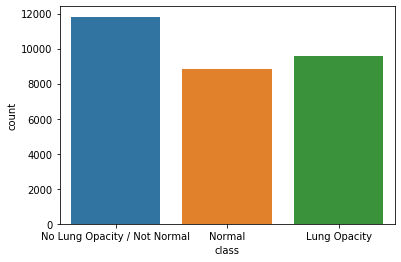

In [8]:
sns.countplot(class_info['class']);

- Not Normal ~ 12000 
- Normal ~ 9000
- Lung Opacity ~ 9500

- Class ditribution is imbalanced - having more records in  class-0 (non-pneumonia) than class-1 (pneumonia)

## Labels data

In [9]:
labels_path = data_path / 'stage_2_train_labels.csv'

In [10]:
labels = pd.read_csv(labels_path)

In [11]:
labels.shape

(30227, 6)

- Total records = 30227

In [12]:
labels.head(2)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0


- Total 6 columns
- 1 for id
- 4 for position of box
- 1 for Target variable

In [13]:
labels['patientId'].nunique()

26684

- Total patients = 26684
- A patient may have multiple records corresponding to each infected area.

In [14]:
n_infected_area = labels.groupby('patientId').sum()['Target']

#### Number of Healthy patients

In [15]:
(n_infected_area==0).sum()

20672

#### Number of infected patients

In [16]:
(n_infected_area!=0).sum()

6012

In [17]:
'Infected Patients - {0:.1f} %'.format(6012/20672*100)

'Infected Patients - 29.1 %'

#### Class distribution

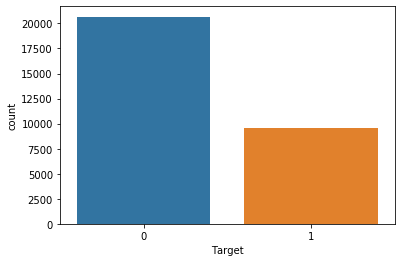

In [18]:
sns.countplot(labels['Target']);

In [19]:
np.bincount(labels['Target'])

array([20672,  9555])

- class-0 (not infected) -- 20672
- class-1 (infected)     -- 9555

#### Here, no. of infected patients is 6012 while number of records in class-1 is 9555, the difference is because  a patient may have more than 1 infected area and thus having more than 1 record per patient 

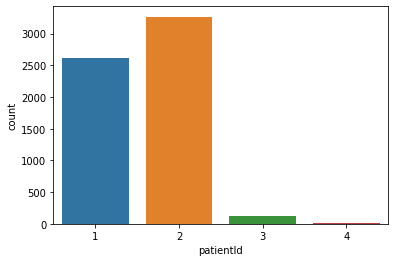

In [20]:
# this plot depicts the distribution of number-of-infected-area among infected patients.
sns.countplot(labels[labels['Target']==1]['patientId'].value_counts());

- Almost all people have 1 or 2 infected areas
- Very few people with 3 or 4 infected areas

Scatter plot for the center of the bounding-box points in the plane x0y.   The centers of the rectangles are the points $$x_c = x + \frac{width}{2}$$ and $$y_c = y + \frac{height}{2}$$

We will show a sample of center points superposed with the corresponding sample of the rectangles.
The rectangles are created using the method described in Kevin's Kernel <a href="#4">[1]</a>


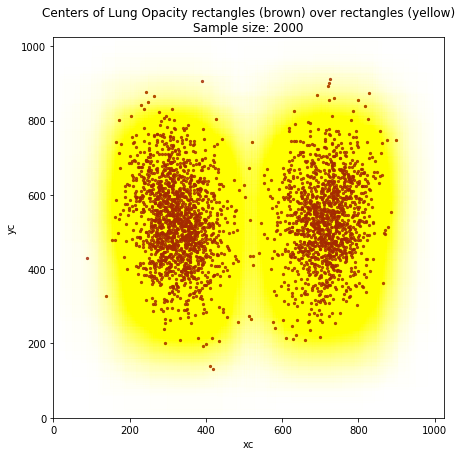

In [21]:
target1 = labels[labels['Target']==1]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
target_sample = target1.sample(3000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title('Centers of Lung Opacity rectangles (brown) over rectangles (yellow)\nSample size: 2000')
target_sample.plot.scatter(x='xc', y='yc', xlim=(0, 1024), ylim=(0, 1024), ax=ax, alpha=0.8, marker=".", color='brown')
for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))
plt.show()

##### For class-0 there are obviously no box coordinates as they are non-pneumonic so all must be nan

In [22]:
labels[labels['Target'] == 0].isna().all()

patientId    False
x             True
y             True
width         True
height        True
Target       False
dtype: bool

###### For class-1 let's check for any nan values

In [23]:
labels[labels['Target'] == 1].isna().sum()

patientId    0
x            0
y            0
width        0
height       0
Target       0
dtype: int64

The `labels` and `class_info` datasets do not share a joining keyword column, but the rows are listed in the exact same order, therefore we can combine the two dataframes by concatenating their columns.

## Distribution of position of bounding-box

In [24]:
# df --> all positive records
df = labels[labels['Target'] == 1]
df.head(2)

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


#### 1. Scatter plot

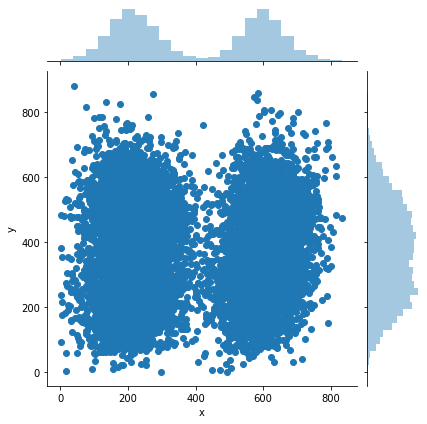

In [25]:
sns.jointplot(x = 'x', y = 'y', data = df, kind = 'scatter');

#### 2. Box plot

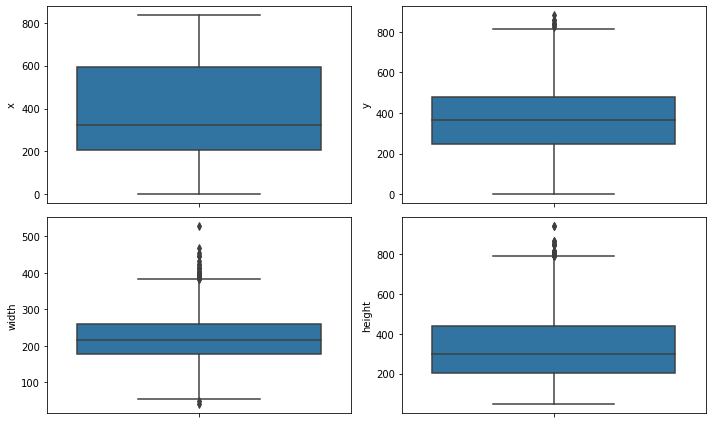

In [26]:
n_columns = 2
n_rows = 2
_, axes = plt.subplots(n_rows, n_columns, figsize=(5 * n_columns, 3 * n_rows))
for i, c in enumerate(df.columns[1:-1]):
    sns.boxplot(y = c, data = df, ax = axes[i // n_columns, i % n_columns])
plt.tight_layout()
plt.show()

## Image data

In [27]:
images_path = data_path / 'stage_2_train_images'

In [28]:
# Total number of patients
n_patient = len(os.listdir(images_path))
n_patient

26684

In [29]:
filename = os.listdir(images_path)[0]

file = dicom.dcmread(images_path / filename)

In [30]:
file.pixel_array.shape

(1024, 1024)

- Given CXR is 1024x1024 dimensional 2-D image. We might perhaps need to reshape the data appropriately.

In [31]:
file.dir()

['AccessionNumber',
 'BitsAllocated',
 'BitsStored',
 'BodyPartExamined',
 'Columns',
 'ConversionType',
 'HighBit',
 'InstanceNumber',
 'LossyImageCompression',
 'LossyImageCompressionMethod',
 'Modality',
 'PatientAge',
 'PatientBirthDate',
 'PatientID',
 'PatientName',
 'PatientOrientation',
 'PatientSex',
 'PhotometricInterpretation',
 'PixelData',
 'PixelRepresentation',
 'PixelSpacing',
 'ReferringPhysicianName',
 'Rows',
 'SOPClassUID',
 'SOPInstanceUID',
 'SamplesPerPixel',
 'SeriesDescription',
 'SeriesInstanceUID',
 'SeriesNumber',
 'SpecificCharacterSet',
 'StudyDate',
 'StudyID',
 'StudyInstanceUID',
 'StudyTime',
 'ViewPosition']

### Above are the attributes of which only a handful are available to us, namely, PatientAge, PatientSex, ViewPosition

In [32]:
def get_attrib(filename):
    '''Returns: tuple, containing age and gender corresponding to filename'''
    id = filename.split('.')[0]
    file = dicom.dcmread(images_path / filename)
    return (id, file.PatientAge, file.PatientSex, file.ViewPosition)

In [33]:
# Using python built-in Multi-Processing API to load age and gender
with ProcessPoolExecutor() as executor:
    a = list(executor.map(get_attrib, os.listdir(images_path)))

In [34]:
attrib = pd.DataFrame(a, columns=['id', 'age', 'gender', 'view-position'])

In [35]:
attrib.head(3)

,id,age,gender,view-position
0,bec78094-d857-42e0-b4fb-c6a67ec1da8e,50,F,PA
1,9bfe74ff-3d81-45eb-ad67-18dc30f6d48a,31,M,PA
2,ce13294e-e01d-4074-86dc-0dd747226a5c,52,M,AP


In [36]:
attrib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             26684 non-null  object
 1   age            26684 non-null  object
 2   gender         26684 non-null  object
 3   view-position  26684 non-null  object
dtypes: object(4)
memory usage: 834.0+ KB


##### age

In [37]:
attrib['age'] = attrib['age'].astype('int8')

In [38]:
attrib.describe().T

,count,mean,std,min,25%,50%,75%,max
age,26684.0,46.982049,16.877806,-108.0,34.0,49.0,59.0,92.0


In [39]:
(attrib['age']<0).sum()

5

- 5 negative

##### gender

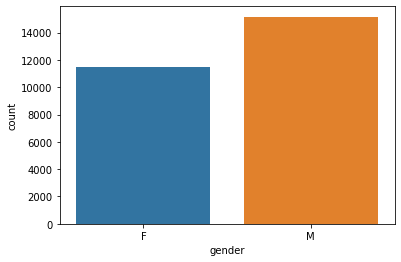

In [40]:
sns.countplot(attrib['gender']);

##### view-position

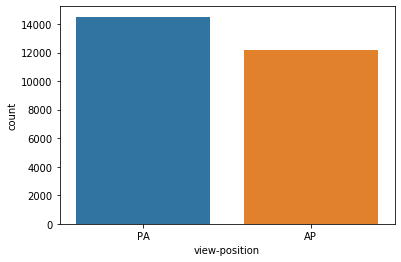

In [41]:
sns.countplot(attrib['view-position']);

#### Plotting CXR images

In [42]:
def plot_image(filename):
    'Display x-ray image with bounding boxes (if applicable) correspondin to filename'
    
    # reading dicom file
    file = dicom.dcmread(images_path / filename)
    
    # id is just 'filename' with it's extension(dcm) having removed
    id = filename.split('.')[0]  
    
    # All records corresponding to a particular id
    # Each record contains Target-variable value (1/0) and box-position information
    records = labels[labels['patientId']==id]
    
    fig, ax = plt.subplots(1)
    
    # Whether this patient (this id) is pneumonic or not
    if (len(records)==1 and records['Target'].values[0]==0):
        has_pneumonia = False
    else:
        has_pneumonia = True

    # If pneumonic then draw the bbox as well else only plot the image
    if has_pneumonia:
        # Iterating over all the records to get bbox
        for i, s in records.iloc[:, 1:5].iterrows():
            bbox = Rectangle((s['x'], s['y']), s['width'], s['height'], color='blue',
                             fill=False)
            ax.add_patch(bbox)
        ax.imshow(file.pixel_array, cmap='gray')
    else:
        ax.imshow(file.pixel_array, cmap='gray')
    
    # which class (of the total 3 classes) does this id belong to
    c = class_info[class_info['patientId'] == id]['class'].values[0]
    ax.set_xlabel(c)

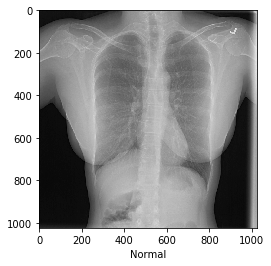

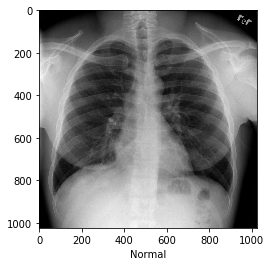

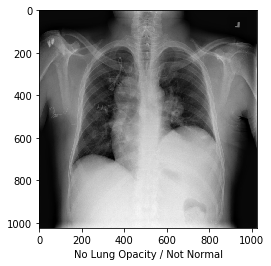

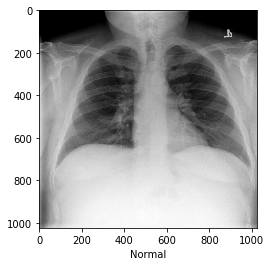

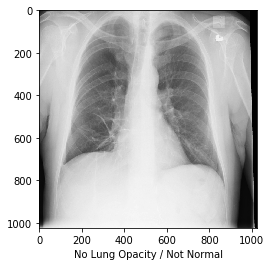

In [43]:
# ploting 5 random scans
for _ in range(5):
    n = np.random.randint(n_patient)
    filename = os.listdir(images_path)[n]
    plot_image(filename)

- This is a object-detection problem, where the 'object' is potentially-infected-area.
- Convolutional Neural Networks have proved to be very successful in object-detection problems. So we are going to build a model based on CNN
- We are going to employ a technique called Transfer Learning, where a pre-trained model is used as a starting point and fine-tuned with a different dataset.

- Data needs to pre-processed according to the chosen algorithm

## Prospective algorithms

- Mask R-CNN is an object instance segmentation and thus can also be used for object-dection. https://github.com/matterport/Mask_RCNN
- DeepLab https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md
- CheXNet algorithm  a 121-layer deep 2D Convolutional Neural Network

Some other algorithms that we can make use of:
- VGG-19 is a convolutional neural network that is 19 layers deep.
- MobileNets are small, low-latency, low-power models parameterized to meet the resource constraints of a variety of use cases.